In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='serif')
import seaborn as sns

from tqdm import tqdm

import pandas as pd

import torch
import torch.distributions as dist

import bruges
from bruges.rockphysics.fluidsub import vels as vels_gassmann
from bruges.rockphysics.bounds import voigt_bound

from geobed import BED_discrete
from geobed.fwd_collection.avo import *

from utils import *

In [3]:
# nuisance parameters

a_1_mean = torch.tensor([2270.0]) # m/s from Ghosh2020
a_1_std = torch.tensor([10.0])    # m/s filler value

b_1_mean = torch.tensor([854.0])  # m/s from Ghosh2020
b_1_std  = torch.tensor([10.0])   # m/s filler value

p_1_mean = torch.tensor([2100.0]) # kg/m3 from Ghosh2020
p_1_std  = torch.tensor([10.0])   # kg/m3 filler value

d_mean = torch.tensor([1000.0])   # m from Dupuy2017
d_std  = torch.tensor([50.0])     # m filler value

# Grain properties
K_grain_mean = torch.tensor([39.3])*1e9              # Pa from Ghosh2020
K_grain_std  = torch.tensor([3.6/100])*K_grain_mean  # Pa from Ghosh2020

G_grain_mean = torch.tensor([44.8])*1e9              # Pa from Ghosh2020
G_grain_std  = torch.tensor([1.8/100])*G_grain_mean  # Pa from Ghosh2020

rho_grain_mean = torch.tensor([2664.0])                  # kg/m3 from Ghosh2020
rho_grain_std  = torch.tensor([0.1/100])*rho_grain_mean  # kg/m3 from Ghosh2020


# Frame properties

K_frame_mean = torch.tensor([2.56])*1e9                 # Pa from Ghosh2020
K_frame_std  = torch.tensor([3.0/100])*K_frame_mean     # Pa from Ghosh2020

G_frame_mean = torch.tensor([8.5])*1e9                  # Pa from Ghosh2020
G_frame_std  = torch.tensor([3.0/100])*G_frame_mean     # Pa from Ghosh2020

k_frame_mean = torch.tensor([2e-12])                    # m2 from Ghosh2020
k_frame_std  = torch.tensor([75.0/100])*k_frame_mean    # m2 from Ghosh2020

m_frame_mean = torch.tensor([1.0])                      # from Ghosh2020
m_frame_std  = torch.tensor([25.0/100])*m_frame_mean    # from Ghosh2020

porosity_mean = torch.tensor([0.37])                    # from Ghosh2020
porosity_std  = torch.tensor([6.75/100])*porosity_mean  # from Ghosh2020

# Brine properties

K_brine_mean = torch.tensor([2.35])*1e9                  # Pa from Ghosh2020
K_brine_std  = torch.tensor([3.24/100])*K_brine_mean     # Pa from Ghosh2020

rho_brine_mean = torch.tensor([1030.0])                  # kg/m3 from Ghosh2020
rho_brine_std  = torch.tensor([1.94/100])*rho_brine_mean # kg/m3 from Ghosh2020

mu_brine_mean = torch.tensor([0.00069])                  # Pa*s from Ghosh2020
mu_brine_std  = torch.tensor([1.5/100])*mu_brine_mean    # Pa*s from Ghosh2020

# CO2 properties

K_co2_mean = torch.tensor([0.08])*1e9                    # Pa from Ghosh2020
K_co2_std  = torch.tensor([53.0/100])*K_co2_mean         # Pa from Ghosh2020

rho_co2_mean = torch.tensor([700.0])                     # kg/m3 from Ghosh2020
rho_co2_std  = torch.tensor([11.0/100])*rho_co2_mean     # kg/m3 from Ghosh2020

mu_co2_mean = torch.tensor([0.000006])                   # Pa*s from Ghosh2020
mu_co2_std  = torch.tensor([17.0/100])*mu_co2_mean       # Pa*s from Ghosh2020
    
prior_table = pd.DataFrame(
    data=[
        [a_1_mean.item(), b_1_mean.item(), p_1_mean.item(), d_mean.item(), K_grain_mean.item(), G_grain_mean.item(), rho_grain_mean.item(), K_frame_mean.item(), G_frame_mean.item(), k_frame_mean.item(), m_frame_mean.item(), porosity_mean.item(), K_brine_mean.item(), rho_brine_mean.item(), mu_brine_mean.item(), K_co2_mean.item(), rho_co2_mean.item(), mu_co2_mean.item()],
        [a_1_std.item(), b_1_std.item(), p_1_std.item(), d_std.item(), K_grain_std.item(), G_grain_std.item(), rho_grain_std.item(), K_frame_std.item(), G_frame_std.item(), k_frame_std.item(), m_frame_std.item(), porosity_std.item(), K_brine_std.item(), rho_brine_std.item(), mu_brine_std.item(), K_co2_std.item(), rho_co2_std.item(), mu_co2_std.item()]
    ],
    index=['mean', 'std'],
    columns=[r'$\alpha_1$', r'$\beta_1$', r'$\rho_1$', r'$d$', r'$K_{grain}$', r'$G_{grain}$', r'$\rho_{grain}$', r'$K_{frame}$', r'$G_{frame}$', r'$k_{frame}$', r'$m_{frame}$', r'$\phi$', r'$K_{brine}$', r'$\rho_{brine}$', r'$\mu_{brine}$', r'$K_{co2}$', r'$\rho_{co2}$', r'$\mu_{co2}$']
)

In [4]:
# display(prior_table.T)

In [5]:
# def sci_notation(number, sig_fig=2):
#     ret_string = "{0:.{1:d}e}".format(number, sig_fig)
#     a, b = ret_string.split("e")
#     # remove leading "+" and strip leading zeros
#     b = int(b)
#     return '$' + a + " \times 10^{" + str(b) + '}$'

# latex_table = prior_table.T

# # print(pd.DataFrame([f'{sci_notation(mean_value, 2)}' for mean_value in latex_table['mean'].values]))

# latex_df = pd.DataFrame(pd.DataFrame([f'{sci_notation(mean_value, 2)}' for mean_value in latex_table['mean'].values]) \
#                 + "±" + pd.DataFrame([f'{sci_notation(mean_value, 2)}' for mean_value in latex_table['std'].values],),
# )
# latex_df = latex_df.T
# latex_df.columns = latex_table.index
# latex_df = latex_df.T

# latex_df.columns = [r'$value \pm std$']

# display(latex_df)

# print(latex_df.to_latex(escape=False, 
# ))


In [6]:
name_to_index = {
    'alpha_1': 0,
    'beta_1': 1,
    'rho_1': 2,
    'd': 3,
    'K_grain': 4,
    'G_grain': 5,
    'rho_grain': 6,
    'K_frame': 7,
    'G_frame': 8,
    'k_frame': 9,
    'm_frame': 10,
    'phi': 11,
    'K_brine': 12,
    'rho_brine': 13,
    'mu_brine': 14,
    'K_co2': 15,
    'rho_co2': 16,
    'mu_co2': 17
}

In [7]:
nuisance_dist = dist.Independent(
    dist.Normal(
        torch.cat([a_1_mean, b_1_mean, p_1_mean, d_mean, K_grain_mean, G_grain_mean, rho_grain_mean, K_frame_mean, G_frame_mean, k_frame_mean, m_frame_mean, porosity_mean, K_brine_mean, rho_brine_mean, mu_brine_mean, K_co2_mean, rho_co2_mean, mu_co2_mean]),
        torch.cat([a_1_std, b_1_std, p_1_std, d_std, K_grain_std, G_grain_std, rho_grain_std, K_frame_std, G_frame_std, k_frame_std, m_frame_std, porosity_std, K_brine_std, rho_brine_std, mu_brine_std, K_co2_std, rho_co2_std, mu_co2_std])
    ),
    1)

In [8]:
# prior parameter

co2_saturations_min = torch.tensor([0.85])
co2_saturations_max = torch.tensor([0.95])

co2_saturations_prior_dist = dist.Independent(dist.Uniform(co2_saturations_min, co2_saturations_max),1)

In [9]:
def get_compute_samples(co2_saturations_prior_samples, nuisance_samples):
    d_nuisance_samples = nuisance_samples[:, name_to_index['d']]

    vp_1_nuisance_samples = nuisance_samples[:, name_to_index['alpha_1']]
    vs_1_nuisance_samples = nuisance_samples[:, name_to_index['beta_1']]
    rho_1_nuisance_samples = nuisance_samples[:, name_to_index['rho_1']]

    K_dry_nuisance_samples = nuisance_samples[:, name_to_index['K_frame']]
    G_dry_nuisance_samples = nuisance_samples[:, name_to_index['G_frame']]

    K_grain_nuisance_samples = nuisance_samples[:, name_to_index['K_grain']]
    G_grain_nuisance_samples = nuisance_samples[:, name_to_index['G_grain']]
    rho_grain_nuisance_samples = nuisance_samples[:, name_to_index['rho_grain']]

    K_brine_nuisance_samples = nuisance_samples[:, name_to_index['K_brine']]
    rho_brine_nuisance_samples = nuisance_samples[:,name_to_index['rho_brine']]

    K_co2_nuisance_samples = nuisance_samples[:, name_to_index['K_co2']]
    rho_co2_nuisance_samples = nuisance_samples[:, name_to_index['rho_co2']]

    porosity_nuisance_samples = nuisance_samples[:, name_to_index['phi']]
    
    water_saturation = 1-co2_saturations_prior_samples

    # voigt_bound
    # From: https://code.agilescientific.com/bruges/_modules/bruges/rockphysics/bounds.html#voigt_bound
    # The upper bound on the effective elastic modulus, mv of a
    #  mixture of N material phases. This is defined at the arithmetic
    #  average of the constituents.

    K_f_nuisance_samples = K_brine_nuisance_samples*water_saturation[:, 0] + K_co2_nuisance_samples*co2_saturations_prior_samples[:, 0]
    rho_f_nuisance_samples = rho_brine_nuisance_samples*water_saturation[:, 0] + rho_co2_nuisance_samples*co2_saturations_prior_samples[:, 0]

    # alternative reuss_bound
    # The lower bound on the effective elastic modulus of a
    # mixture of N material phases. This is defined at the harmonic
    # average of the constituents. Same as Wood's equation for homogeneous mixed fluids.
    
    vp_2_nuisance_samples, vs_2_nuisance_samples, rho_2_nuisance_samples, _ = vels_gassmann(
        Kdry=K_dry_nuisance_samples, 
        Gdry=G_dry_nuisance_samples,
        K0=K_grain_nuisance_samples,
        D0=rho_grain_nuisance_samples,
        Kf=K_f_nuisance_samples,
        Df=rho_f_nuisance_samples,
        phi=porosity_nuisance_samples,
        )
    
    vp_2_nuisance_samples, vs_2_nuisance_samples, rho_2_nuisance_samples, _ = vels_gassmann(
    Kdry=K_dry_nuisance_samples, 
    Gdry=G_dry_nuisance_samples,
    K0=K_grain_nuisance_samples,
    D0=rho_grain_nuisance_samples,
    Kf=K_f_nuisance_samples,
    Df=rho_f_nuisance_samples,
    phi=porosity_nuisance_samples,
    )

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    ax.hist(vp_2_nuisance_samples[:int(1e4)], bins=50, density=True, color='k', alpha=0.5, label='vp')
    ax.hist(vs_2_nuisance_samples[:int(1e4)], bins=50, density=True, color='b', alpha=0.5, label='vs')

    ax.legend()

    plt.show()
    
    prior_samples_computation = torch.cat([
        d_nuisance_samples.unsqueeze(1),
        vp_1_nuisance_samples.unsqueeze(1),
        vp_2_nuisance_samples.unsqueeze(1),
        vs_1_nuisance_samples.unsqueeze(1),
        vs_2_nuisance_samples.unsqueeze(1),
        rho_1_nuisance_samples.unsqueeze(1),
        rho_2_nuisance_samples.unsqueeze(1),
        ], dim=1
    ).T.unsqueeze(2).swapaxes(0,1)
    
    return prior_samples_computation

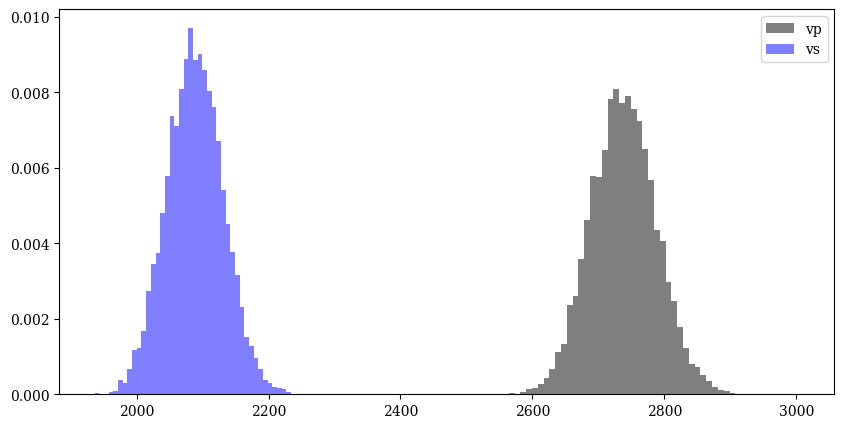

torch.Size([100000, 7, 1])


In [10]:
n_prior_samples = int(1e5)

torch.manual_seed(0)
nuisance_samples = nuisance_dist.sample((n_prior_samples,))
co2_saturations_prior_samples = co2_saturations_prior_dist.sample((n_prior_samples,))

prior_samples_computation = get_compute_samples(co2_saturations_prior_samples, nuisance_samples)

print(prior_samples_computation.shape)

In [11]:
from geobed.fwd_collection import zoeppritz_solver, zoeppritz_solver_rpp

In [12]:
def forward_function(offset, params):
    
    offset = offset[None, :].T
    params = params.swapaxes(0,1)
    
    theta_1 = torch.atan( offset / (2 * params[0]) )
        
    return zoeppritz_solver_rpp(theta_1, params[1], params[2], params[3], params[4], params[5], params[6]).swapaxes(-2,-1)

In [13]:
n_design_points = 200
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(100.0, 4000.0, n_design_points)

design_dicts = {}

filename_core = 'interrogation_design/interrogation_design_uniform_co2_question_test'
filename = f"data/{filename_core}_{n_prior_samples}_{n_design_points}.h5"

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'file': filename, 'dataset': 'data', 'cost': 1.0,}

In [14]:
print(prior_samples_computation.shape)

torch.Size([100000, 7, 1])


In [15]:
prior_samples_computation = generate_lookup_table(
    filename,
    prior_samples_computation,
    offsets,
    forward_function,
    transpose_order=(2, 0, 1),
    n_parallel = 20)

generating lookup table
starting parallel processing


  0%|          | 0/200 [00:00<?, ?it/s]

dimensions: (n_prior, n_design, data_dim)
(100000, 200, 1) float32 

20000000
0


In [16]:
def data_likelihood(samples, **kwargs):

    std_data = 0.05
    
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)
    
    return data_likelihood

In [17]:
prior_samples_computation.shape

torch.Size([100000, 7, 1])

In [18]:
from geobed import BED_discrete

BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=co2_saturations_prior_samples,
                         design2data='lookup_1to1_fast')

No prior distribution given. Variational posterior will only be accurate up to a constant.
                   This is fine for the optimisation but just a heads up.
No prior distribution defined. Setting prior entropy to 0. This has no effect on the design optimisation.


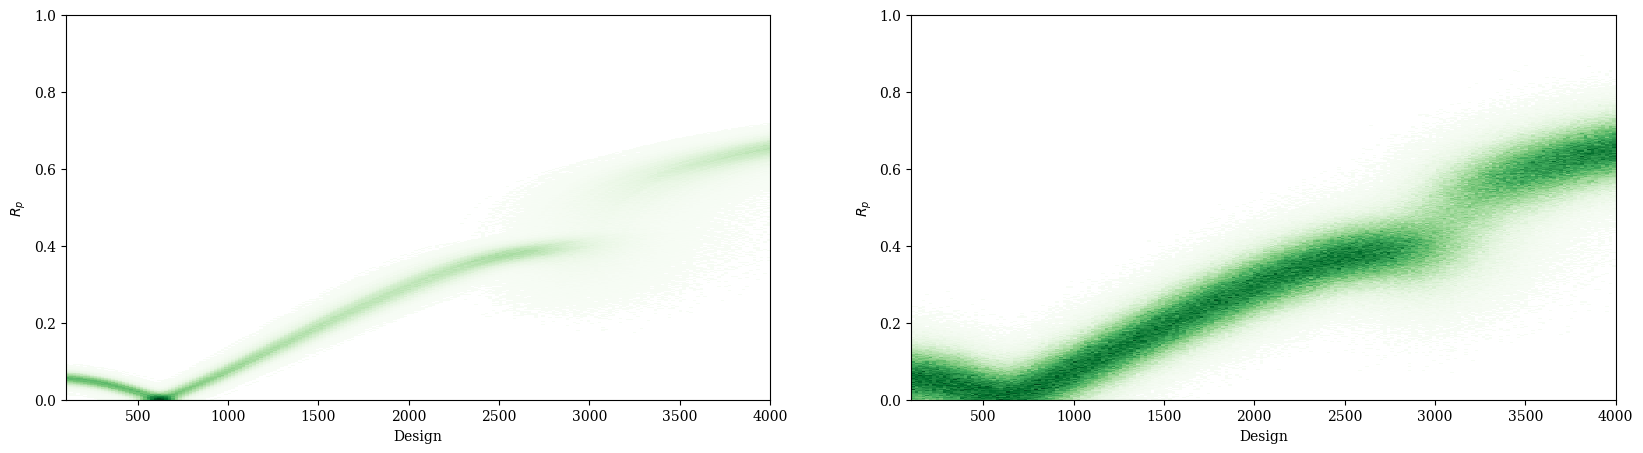

In [19]:
n_visual = int(1e4)

clean_samples = BED_class.get_forward_samples(   design_names, n_samples=n_visual)
noisy_samples = BED_class.get_likelihood_samples(design_names, n_samples=n_visual)

offsets = torch.tensor([d['offset'] for d in design_dicts.values()])

fig = plt.figure(figsize=(20, 5))
ax_dict = fig.subplot_mosaic('''ab''')

ax_dict['a'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), clean_samples.flatten().numpy(),
                    bins=[n_design_points, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), noisy_samples.flatten().numpy(),
                    bins=[n_design_points, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set(xlabel='Design', ylabel=r'$R_p$', ylim=(0, 1))
ax_dict['b'].set(xlabel='Design', ylabel=r'$R_p$', ylim=(0, 1))
                
plt.show()

In [20]:
optimal_design_dict = {}
info_dict = {}

design_budget = 4
n_parallel = 40

In [21]:
method = 'nmc'

M = int(5e3)
N = int(5e3)

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs={'N': N, 'M': M, 'reuse_M_samples':True, 'memory_efficient':True},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename=f'data/{filename_core}_bed_{method}.pkl',
    )

  0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
# plt.figure(figsize=(20, 5))
# plt.plot(offsets, info_dict[method][1]['eig'], label='eig')
# plt.show()

In [23]:
from geobed.guides import MDN_guide

method = 'variational_posterior'

T = int(1e5)

N = int(T * 0.2)
M = int(T * 0.8)

n_grad_steps = 10000

def n_batch_schedule(M, **kwargs):
    return 50

def n_epochs_schedule(M, n_batch, **kwargs):
    return max(min(200, (n_grad_steps*n_batch)//(M)), 4)

def scheduler_step_size_schedule(n_epochs, **kwargs):
    return n_epochs//3

n_batch = n_batch_schedule(**{'M':M})
n_epochs = n_epochs_schedule(**{'M':M, 'n_batch':n_batch})
step_size = scheduler_step_size_schedule(**{'n_epochs':n_epochs})
print(n_batch, n_epochs, step_size)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs=
    {'guide': MDN_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':10, 'hidden_features':[50, 50, 50], 'normalize':True,},
     'n_batch': n_batch_schedule,
     'n_epochs': n_epochs_schedule,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-4},
     'scheduler': torch.optim.lr_scheduler.StepLR,
     'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': False,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename=f'data/{filename_core}_bed_{method}.pkl',
)

50 6 2


  0%|          | 0/4 [00:00<?, ?it/s]

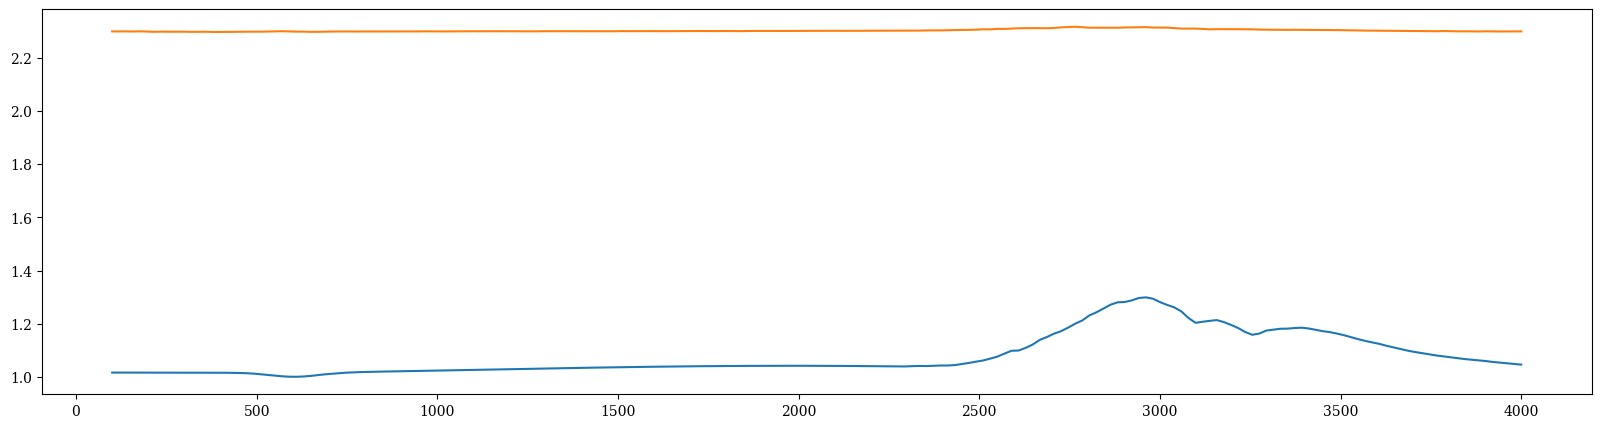

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(offsets, info_dict['nmc'][3]['eig'], label='eig')
plt.plot(offsets, info_dict['variational_posterior'][3]['eig'], label='eig')
plt.show()

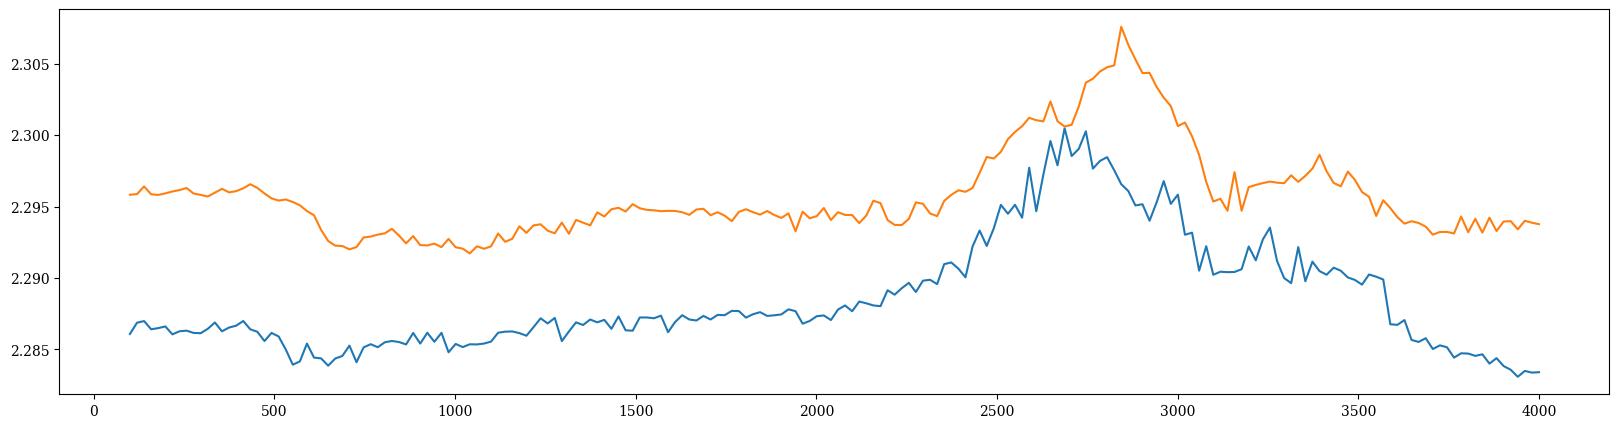

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(offsets, info_dict['variational_posterior'][1]['eig'], label='eig')
plt.plot(offsets, info_dict['variational_posterior'][2]['eig'], label='eig')
plt.show()

In [26]:
n_rec = 2

nmc_design = optimal_design_dict['nmc'][:n_rec]
variational_posterior_design = optimal_design_dict['variational_posterior'][:n_rec]

nmc_design_offsets = torch.tensor([design_dicts[d]['offset'] for d in nmc_design])
variational_posterior_design_offsets = torch.tensor([design_dicts[d]['offset'] for d in variational_posterior_design])

if n_rec > 2:
    heuristic_design_offsets = torch.linspace(1000, 3000, n_rec)
elif n_rec == 2:
    heuristic_design_offsets = torch.tensor([1500, 2500])
elif n_rec == 1:
    heuristic_design_offsets = torch.tensor([2000])
    
heuristic_design = [str(np.argmin(np.abs(offsets - o)).item()) for o in heuristic_design_offsets]

optimal_designs = [
    nmc_design,
    variational_posterior_design,
    heuristic_design,
]
    
print(optimal_designs) 

optimal_designs_offsets = torch.stack(
    [nmc_design_offsets,
     variational_posterior_design_offsets,
     heuristic_design_offsets,
     ],
    dim=0,
    ).float().numpy()

print(optimal_designs_offsets)

[['153', '161'], ['132', '140'], ['71', '122']]
[[3098.4924 3255.2764]
 [2686.9346 2843.7185]
 [1500.     2500.    ]]


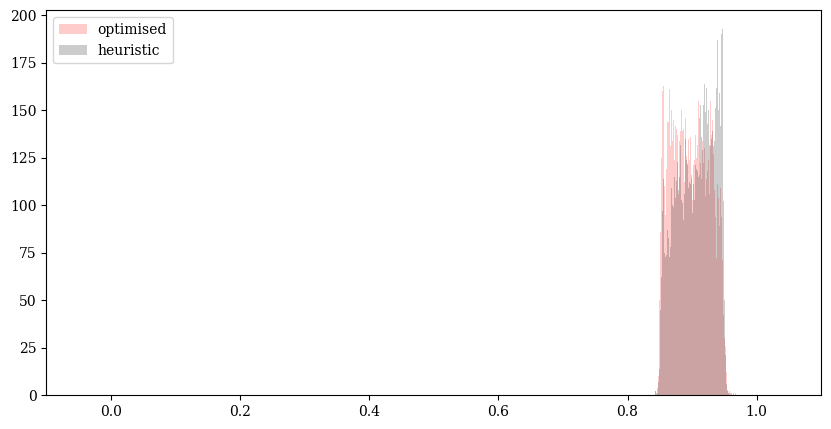

In [27]:
import seaborn as sns

var_post_info = info_dict['variational_posterior'][2]['info']

torch.manual_seed(0)
data_test              = BED_class.get_likelihood_samples(design_names, n_samples=100)

# design = [str(np.argmin(np.abs(offsets - o)).item()) for o in design_offsets]

alpha = 0.2

i_sample = 22

fig, ax = plt.subplots(figsize=(10, 5))

design = [variational_posterior_design[0],]
var_post_out = var_post_info[int(design[0])]['guide'].sample(data_test[i_sample:i_sample+1, [design_dicts[d]['index'] for d in design]], n_samples=10000)
ax.hist(var_post_out.flatten().numpy(), bins=100, density=False, label='optimised', alpha=alpha, color='red')

design_offsets = [2000,]
design = [str(np.argmin(np.abs(offsets - o)).item()) for o in design_offsets]

heuristic_out = var_post_info[int(design[0])]['guide'].sample(data_test[i_sample:i_sample+1, [design_dicts[d]['index'] for d in design]], n_samples=10000)
ax.hist(heuristic_out.flatten().numpy(), bins=100, density=False, label='heuristic', alpha=alpha, color='k')

ax.set_xlim(-0.1, 1.1)

ax.legend()

plt.show()

(0.0, 3.0)

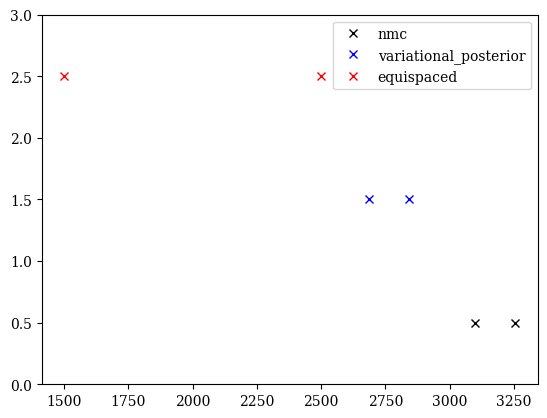

In [28]:
heuristic_design = [str(np.argmin(np.abs(offsets - o)).item()) for o in heuristic_design_offsets]

plt.plot(nmc_design_offsets, 0.5*np.ones(n_rec), 'kx', label='nmc',)
plt.plot(variational_posterior_design_offsets, 1.5*np.ones(n_rec), 'bx', label='variational_posterior',)
plt.plot(heuristic_design_offsets, 2.5*np.ones(n_rec), 'rx', label='equispaced')

plt.legend()

plt.ylim(0, 3)

In [29]:
# n_prior_samples_benchmark = int(1e6)

# torch.manual_seed(1)
# nuisance_samples_benchmark = nuisance_dist.sample((n_prior_samples_benchmark,))
# co2_saturations_prior_samples_benchmark = co2_saturations_prior_dist.sample((n_prior_samples_benchmark,))

# prior_samples_computation_benchmark = get_compute_samples(co2_saturations_prior_samples_benchmark, nuisance_samples_benchmark)

# print(prior_samples_computation_benchmark.shape)

In [30]:
# design_dicts_benchmark = {}

# filename_benchmark = f"data/{filename_core}_benchmark_{n_prior_samples_benchmark}_{n_design_points}.h5"

# for i, name in enumerate(design_names):
#     design_dicts_benchmark[name] = {'index': i, 'offset': offsets[i], 'file': filename_benchmark, 'dataset': 'data', 'cost': 1.0,}

In [31]:
# prior_samples_computation_benchmark = generate_lookup_table(
#     filename_benchmark,
#     prior_samples_computation_benchmark,
#     offsets,
#     forward_function,
#     transpose_order=(2, 0, 1),
#     n_parallel = n_parallel)

In [32]:
# from geobed import BED_discrete

# BED_class_benchmark = BED_discrete(design_dicts_benchmark, data_likelihood, prior_samples=co2_saturations_prior_samples_benchmark,
#                          design2data='lookup_1to1_fast')

In [ ]:
# n_visual = int(1e4)

# clean_samples = BED_class_benchmark.get_forward_samples(   design_names, n_samples=n_visual)
# noisy_samples = BED_class_benchmark.get_likelihood_samples(design_names, n_samples=n_visual)

# offsets = torch.tensor([d['offset'] for d in design_dicts.values()])

# fig = plt.figure(figsize=(20, 5))
# ax_dict = fig.subplot_mosaic('''ab''')

# ax_dict['a'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), clean_samples.flatten().numpy(),
#                     bins=[n_design_points, 400], cmap='Greens', cmin=1)

# ax_dict['b'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), noisy_samples.flatten().numpy(),
#                     bins=[n_design_points, 400], cmap='Greens', cmin=1)
    
# ax_dict['a'].set(xlabel='Design', ylabel=r'$R_p$', ylim=(0, 1))
# ax_dict['b'].set(xlabel='Design', ylabel=r'$R_p$', ylim=(0, 1))
                
# plt.show()

In [ ]:
# from geobed.guides import MDN_guide

# method = 'variational_posterior'

# T = int(1e5)

# N = int(T * 0.2)
# M = int(T * 0.8)

# n_grad_steps = 10000

# def n_batch_schedule(M, **kwargs):
#     return 50

# def n_epochs_schedule(M, n_batch, **kwargs):
#     return max(min(200, (n_grad_steps*n_batch)//(M)), 4)

# def scheduler_step_size_schedule(n_epochs, **kwargs):
#     return n_epochs//3

# n_batch = n_batch_schedule(**{'M':M})
# n_epochs = n_epochs_schedule(**{'M':M, 'n_batch':n_batch})
# step_size = scheduler_step_size_schedule(**{'n_epochs':n_epochs})
# print(n_batch, n_epochs, step_size)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

# optimal_design_benchmark, info_benchmark = BED_class_benchmark.calculate_eig_list(
#     design_list=optimal_designs,
#     method=method,
#     method_kwargs=
#     {'guide': MDN_guide,
#      'N': N,
#      'M': M,
#      'guide_kwargs': {'components':10, 'hidden_features':[50, 50, 50], 'normalize':True,},
#      'n_batch': n_batch_schedule,
#      'n_epochs': n_epochs_schedule,
#     #  'optimizer': torch.optim.Adam,
#      'optimizer_kwargs': {'lr': 1e-4},
#      'scheduler': torch.optim.lr_scheduler.StepLR,
#      'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
#      'return_guide': True,
#      'return_train_loss': True,
#      'return_test_loss': True,
#      'progress_bar': True,
#      },
#     num_workers=len(optimal_designs),
#     filename=f'data/{filename_core}_bed_benchmark.pkl',
# )

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(np.arange(0, n_epochs*M/n_batch, 1), info_benchmark[0]['train_loss'], label='train_loss', color='grey', alpha=0.5)
# ax.plot(np.arange(M/n_batch, (n_epochs+1)*M/n_batch, M/n_batch), info_benchmark[0]['test_loss'], 'o', label='test_loss', color='orange')

# plt.show()

In [ ]:
# nmc_design_eig, variational_posterior_design_eig, heuristic_design_eig = optimal_design_benchmark.tolist()

# print('nmc_eig:', f'{nmc_design_eig:.2f}')
# print('variational_posterior_eig:', f'{variational_posterior_design_eig:.2f}')
# print('heuristic_eig:', f'{heuristic_design_eig:.2f}')

In [ ]:
# import random

# n_random_designs = int(1000)

# random_design_list = [random.sample(design_names, n_rec) for i in range(n_random_designs)]

# print(np.array(random_design_list).shape)

In [ ]:
# random_designs_benchmark, info_random_designs_benchmark = BED_class_benchmark.calculate_eig_list(
#     design_list=random_design_list,
#     method=method,
#     method_kwargs=
#     {'guide': MDN_guide,
#      'N': N,
#      'M': M,
#      'guide_kwargs': {'components':10, 'hidden_features':[50, 50, 50], 'normalize':True,},
#      'n_batch': n_batch_schedule,
#      'n_epochs': n_epochs_schedule,
#     #  'optimizer': torch.optim.Adam,
#      'optimizer_kwargs': {'lr': 1e-4},
#      'scheduler': torch.optim.lr_scheduler.StepLR,
#      'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
#      'return_guide': False,
#      'return_train_loss': False,
#      'return_test_loss': True,
#      'progress_bar': False,
#      },
#     num_workers=n_parallel,
#     filename=f'data/{filename_core}_bed_benchmark_random_designs.pkl',
#     progress_bar=True,
# )

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# # ax.hist(random_designs_benchmark, bins=20, density=True, label='random designs', alpha=0.5)
# sns.kdeplot(random_designs_benchmark, ax=ax, label='random designs', 
#             color='tab:blue', linewidth=0, alpha=0.3, bw_adjust=0.4, cut=0,
#             fill=True)

# # ax.set_xlim([0.85, 1.6])
# ax.set_ylim([0, 7.0])
# vertical_offset = ax.get_ylim()[1] * 0.98

# fontsize = 12
# ymin = 0.0
# lw=2.0

# # ax.axvline(nmc_design_eig, ymin=ymin, color='k' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
# # ax.text(nmc_design_eig+0.005, vertical_offset, 'NMC', rotation=90, color='k', fontsize=fontsize, verticalalignment='top')

# ax.axvline(variational_posterior_design_eig, ymin=ymin, color='cyan', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
# ax.text(variational_posterior_design_eig+0.005, vertical_offset, 'variational posterior', rotation=90, color='cyan', fontsize=fontsize, verticalalignment='top')

# ax.axvline(heuristic_design_eig, ymin=ymin, color='orange', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
# ax.text(heuristic_design_eig+0.005, vertical_offset, 'heuristic', rotation=90, color='orange', fontsize=fontsize, verticalalignment='top')

# ax.set_xlabel('EIG')
# ax.set_ylabel('density')

# ax.text(0.05, vertical_offset*0.45, 'random designs', rotation=0, color='tab:blue',
#         fontsize=fontsize, verticalalignment='center', alpha=0.5, )

# fig.savefig('figures/interrogation/interrogation_uniform_dn_eig_comparison.pdf', bbox_inches='tight', transparent=True, dpi=150)
# fig.savefig('figures/interrogation/interrogation_uniform_dn_eig_comparison.png', bbox_inches='tight', transparent=True, dpi=150)

# plt.show()

In [ ]:
# plt.rc('font', family='sans-serif')

# design_list = [heuristic_design_offsets,
#                nmc_design_offsets,
#                variational_posterior_design_offsets,
#                [2109.091, 2463.6362],
#                ]

# fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# # design_list = torch.stack([optimal_design_heuristic, optimal_design_sgd_equispaced, optimal_design_sgd_heuristic,
#                         #    optimal_design_guest, iterative_benchmark_design])

# titles = [
#     'Heuristic',
#     'NMC (all parameters)',
#     r'$CO_2$ saturation?',
#     r'$CO_2$ leaking?',
#     ]

# for i, design in enumerate(design_list):

#     off = 1 * (i+1)

#     ax.plot(design, off * np.ones_like(design),
#             marker='v', markersize=8, linestyle='None', clip_on=False, color='k', fillstyle='none', markeredgewidth=1.0)
#     ax.axhline(off-0.08, xmin=0, xmax=1, color='k', linestyle='-', linewidth=1.0)

#     ax.plot([0,], [off-0.08,], marker='*', clip_on=False, markersize=10, color='k', linestyle='None')
    
#     ax.text(200, off+0.3, titles[i], fontsize=12, ha='left', va='center')

#     # ax.text(2500, off+0.3, f'EIG $= {eig_mean[i]:.2f} \pm {eig_std[i]:.2f}$', fontsize=12, ha='left', va='center')


# ax.set_xlim(0, 3500)
# ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000,])
# ax.set_xticks(np.linspace(500, 3000, 26), minor=True)

# ax.set_ylim(0.5, len(design_list)+0.5)
# ax.set_yticks([])

# for spine in ['top', 'right', 'left']:
#     ax.spines[spine].set_visible(False)
    
# fig.savefig('figures/interrogation/interrogation_design_comparison.pdf', bbox_inches='tight', transparent=True, dpi=150)
# fig.savefig('figures/interrogation/interrogation_design_comparison.png', bbox_inches='tight', transparent=True, dpi=150)

# plt.show()